In [12]:
# -*- coding: utf-8 -*-
import pandas as pd
from pandas._libs.tslibs import timestamps
from datetime import datetime
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pymysql
from  sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from datetime import datetime
import joblib
from sklearn.metrics import mean_squared_error,confusion_matrix, accuracy_score
from mpl_toolkits.mplot3d import Axes3D
Axes3D = Axes3D  # pycharm auto import
#Import the Keras libraries and packages
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense,Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [13]:
mydb=pymysql.connect(host='localhost',port=int(3306),user='root',passwd='',db='sensor_data') 
#waterlevel range 1
query1 = "Select cast(timestamp as char) as Date,cast(thingName as char) as waterLevel, ROW_NUMBER() OVER (ORDER BY id) row_num , cast(value as char) as water_value  FROM sensor_data WHERE thingName ='NIVÅ029' AND data_type='waterLevelMmAdjustedRH2000' ;"
df1 = pd.read_sql(query1,mydb)
#print(df1)
#sea level
query2 = "Select cast(thingName as char) as seaLevel,ROW_NUMBER() OVER (ORDER BY id) row_num, cast(value as char) as sea_value FROM sensor_data WHERE thingName BETWEEN 'NIVÅ015' AND 'NIVÅ016' AND data_type='waterLevelMmAdjustedRH2000' ;"
df2 = pd.read_sql(query2,mydb)
#print(df2)
#ground water
query3 = "Select  cast(thingName as char) as groundLevel, ROW_NUMBER() OVER (ORDER BY id) row_num, cast(value as char) as ground_value,smhi_rain  FROM sensor_data WHERE data_type='waterLevel' ;"
df3 = pd.read_sql(query3,mydb)

In [14]:
#Separate dates for future plotting
df1["Date"] = pd.to_datetime(df1["Date"])
train_dates = df1["Date"] 

print(train_dates)
#print(train_dates.tail(15))#Check last few dates. 
 
df1_1=pd.DataFrame(df1[["row_num","waterLevel","water_value"]])
df2_2=pd.DataFrame(df2[["row_num","seaLevel","sea_value"]])
df3_3=pd.DataFrame(df3[["row_num","groundLevel","ground_value","smhi_rain"]])
#print reading result
print(df1_1)
print(df2_2)
print(df3_3)
# concatniting data
#dataframe=[df3_3,df2_2,df1_1]
#df1.merge(df2_2,how='left', left_on='Column1', right_on='ColumnA')
df=pd.merge(df3_3,df1_1, on='row_num')
df_last=pd.merge(df,df2_2, on='row_num')
print(df_last)

 # x, y with sklearn convert to nump.ndarray
df_last = df_last[["water_value","smhi_rain","sea_value","ground_value"]].to_numpy()# here we have 4 variables for multiple regression. 
#y = df_last[["water_value"]].to_numpy() 
#df_last=pd.merge(x,y, on="row_num")
    #print(x)
print(df_last)

0      2021-05-28 22:58:36
1      2021-05-28 21:53:10
2      2021-05-28 20:58:22
3      2021-05-28 19:56:46
4      2021-05-28 18:54:59
               ...        
1515   2021-08-04 04:50:54
1516   2021-08-04 03:49:50
1517   2021-08-04 03:00:19
1518   2021-08-04 01:56:29
1519   2021-08-04 00:57:02
Name: Date, Length: 1520, dtype: datetime64[ns]
      row_num waterLevel water_value
0           1    Nivå029        -404
1           2    Nivå029        -381
2           3    Nivå029        -358
3           4    Nivå029        -330
4           5    Nivå029        -295
...       ...        ...         ...
1515     1516    Nivå029        -601
1516     1517    Nivå029        -597
1517     1518    Nivå029        -596
1518     1519    Nivå029        -594
1519     1520    Nivå029        -592

[1520 rows x 3 columns]
      row_num seaLevel sea_value
0           1  Nivå016        79
1           2  Nivå016       103
2           3  Nivå016       111
3           4  Nivå016       134
4           5  Nivå01

In [15]:
# normalize the dataset
scaler = StandardScaler()
scaler=scaler.fit(df_last)
df_x=scaler.transform(df_last)
# splitting the data
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
#print(x_train)

In [16]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 4. We will make timesteps = 15 (past days data used for training). 

#Empty lists to be populated using formatted training data
x_train = []
y_train = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 15  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#the df_x has a shape (3208, 4)
#3208 refers to the number of data points and 4 refers to the columns (multi-variables).
for i in range(n_past, len(df_x) - n_future +1):
    x_train.append(df_x[i - n_past:i, 0:df_x.shape[1]])
    y_train.append(df_x[i + n_future - 1:i + n_future, 0])

x_train,y_train = np.array(x_train), np.array(y_train)

print(x_train)
print(y_train)
print('x_train shape == {}.'.format(x_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

[[[ 9.62457475e-01  4.06994068e-01 -9.87950940e-04 -4.74003544e-01]
  [ 1.08588839e+00  4.06994068e-01  2.72045763e-01 -4.74003544e-01]
  [ 1.20931930e+00  4.06994068e-01  3.63057002e-01 -4.74003544e-01]
  ...
  [-5.71891849e-02  4.06994068e-01  4.08562621e-01 -4.74003544e-01]
  [-5.71891849e-02  4.06994068e-01  7.38478359e-01 -4.74003544e-01]
  [-3.57229394e-02  4.06994068e-01  3.51680597e-01 -4.74003544e-01]]

 [[ 1.08588839e+00  4.06994068e-01  2.72045763e-01 -4.74003544e-01]
  [ 1.20931930e+00  4.06994068e-01  3.63057002e-01 -4.74003544e-01]
  [ 1.35958302e+00  4.06994068e-01  6.24714311e-01 -4.74003544e-01]
  ...
  [-5.71891849e-02  4.06994068e-01  7.38478359e-01 -4.74003544e-01]
  [-3.57229394e-02  4.06994068e-01  3.51680597e-01 -4.74003544e-01]
  [-1.96232553e-02  4.06994068e-01  6.92972740e-01 -4.74003544e-01]]

 [[ 1.20931930e+00  4.06994068e-01  3.63057002e-01 -4.74003544e-01]
  [ 1.35958302e+00  4.06994068e-01  6.24714311e-01 -4.74003544e-01]
  [ 1.54741266e+00  4.06994068e-

In [17]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse',metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 15, 64)            17664     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
85/85 [==============================] - 69s 63ms/step - loss: 0.6084 - mean_squared_error: 0.6084 - mean_absolute_error: 0.4476 - mean_absolute_percentage_error: 88.6613 - val_loss: 1.9372 - val_mean_squared_error: 1.9372 - val_mean_absolute_error: 1.0862 - val_mean_absolute_percentage_error: 1396.5533
Epoch 2/5
85/85 [==============================] - 2s 20ms/step - loss: 0.4943 - mean_squared_error: 0.4943 - mean_absolute_error: 0.3236 - mean_absolute_percentage_error: 75.0838 - val_loss: 1.6198 - val_mean_squared_error: 1.6198 - val_mean_absolute_error: 0.9344 - val_mean_absolute_percentage_error: 757.4336
Epoch 3/5
85/85 [==============================] - 1s 13ms/step - loss: 0.4680 - mean_squared_error: 0.4680 - mean_absolute_error: 0.3320 - mean_absolute_percentage_error: 78.6066 - val_loss: 0.8049 - val_mean_squared_error: 0.8049 - val_mean_absolute_error: 0.5865 - val_mean_absolute_percentage_error: 383.3849
Epoch 4/5
85/85 [==============================] - 1s 13ms/

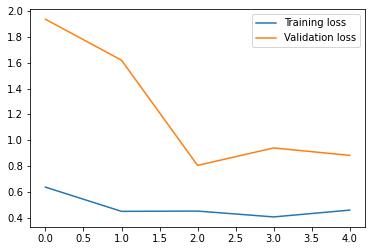

In [18]:
# fit the model
history = model.fit(x_train, y_train, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

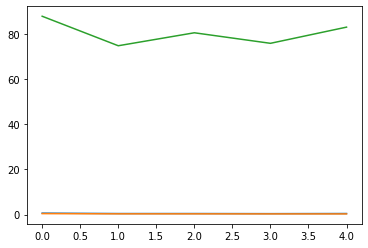

In [19]:
# plot metrics
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['mean_absolute_percentage_error'])

plt.show()

        Date  Water_Level_last
0 2021-09-12       -515.870789
1 2021-09-13       -512.680237
2 2021-09-14       -513.366821
3 2021-09-15       -511.229706
4 2021-09-16       -510.879395
5 2021-09-17       -509.688751
6 2021-09-18       -509.093903
                    Date water_value
1513 2021-08-04 07:00:14        -600
1514 2021-08-04 05:54:34        -604
1515 2021-08-04 04:50:54        -601
1516 2021-08-04 03:49:50        -597
1517 2021-08-04 03:00:19        -596
1518 2021-08-04 01:56:29        -594
1519 2021-08-04 00:57:02        -592


C:\Users\alha1207\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Water_Level_last'>

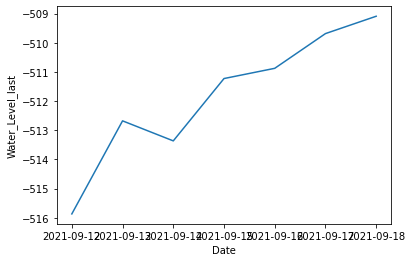

In [20]:
n_future=7
#n_past = 16
#n_days_for_prediction=15
#print(train_dates)
#train_dates=pd.to_datetime(pd.Series(df1["Date"]))
#print(train_dates)
#list(train_dates)[-1]
forecast_period_dates = pd.date_range(start=datetime.now(), periods=n_future, freq='1D').tolist()
#print(forecast_period_dates)
#predict the next 7 days
#print(x_train)
forecast = model.predict(x_train[-n_future:])
#print(forecast)
forecast_copies =np.repeat(forecast, df_last.shape[1],axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
#print(forecast_copies)
#print(y_pred_future)
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Water_Level_last':y_pred_future})
df_forecast["Date"]=pd.to_datetime(df_forecast["Date"])
print(df_forecast)

original = df1[["Date","water_value"]]
original = original.tail(7)
print(original)
#original["Date"]=df1["Date"]
#original = original.loc[original["Date"] >= '2021-8-4']
#print(original)
#sns.set(rc={'figure.figsize':(8,8)})
#sns.lineplot(original["Date"], original["water_value"])
sns.lineplot(df_forecast["Date"], df_forecast["Water_Level_last"])

In [21]:
#test values
predicted_waterLevel = df_forecast["Water_Level_last"] 
print("Water Level for next 7 days :\n",df_forecast) 
for i in predicted_waterLevel:
    if(i > 0): 
         print("Will flood soon") 
    else:
         print("Water level is OK") 
dir='C:\\Users\\alha1207\\ANN\\output\\'
filename ='ANN_model_8.sav' 
joblib.dump(predicted_waterLevel, dir + filename)

Water Level for next 7 days :
         Date  Water_Level_last
0 2021-09-12       -515.870789
1 2021-09-13       -512.680237
2 2021-09-14       -513.366821
3 2021-09-15       -511.229706
4 2021-09-16       -510.879395
5 2021-09-17       -509.688751
6 2021-09-18       -509.093903
Water level is OK
Water level is OK
Water level is OK
Water level is OK
Water level is OK
Water level is OK
Water level is OK


['C:\\Users\\alha1207\\ANN\\output\\ANN_model_8.sav']

In [11]:
## database cloding 
mydb.close() #close the connection
print("Database closed!")

Database closed!
